# Final Report for Leeds Road Safety Plan for 2021
---
Date: 25.02.2021
Group 9: 

## Required Libraries
---

In [1]:
import pandas as pd                         # used to store the datasets
import numpy as np                          # used for numerical calculations on individual column
import matplotlib.pyplot as plt             # plotting 
import seaborn as sns                       # plotting numerical against categorical variables
import textwrap                             # prettify axis labelling
import json                                 # data transfer to json format
import os                                   # automates saving of export files (figures, numerical summaries, ...)
import folium                               # spatial visualisation
from scipy.stats import chi2_contingency    # chi2 statistical association test

## Constants

In [2]:
# path lookup dictionary to store the relative paths from the directory containing the jupyter notebooks to important directories in the project
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"
PATH["references"] = "../data/references/"
PATH['reports'] = {}
PATH['reports']['accidents'] = '../reports/accidents/'
PATH['reports']['casualties'] = '../reports/casualties/'
PATH['reports']['vehicles'] = '../reports/vehicles/'


# filename lookup dictionary storing the most relevant filenames
FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" # the original dataset has a small typing mistake
FILENAME["variable_lookup"] = "variable lookup.xls"

DATA_RAW = {}

DATA_LEEDS = {}

DATA_LEEDS_BIKES = {}

VARIABLE_LOOKUP = {}

SUMMARY = {}

# list of internal names for datasets
TABLENAMES = ["accidents", "casualties", "vehicles"]

# Loading, Inspection and Processing of Datasets (TASK 0)
---

## Loading in the Dataset
---
Starting of the data analysis, we import the given three datasets into a 'pandas' dataframe. 

In [3]:
# load all three datasets using pandas into the predefined dictionary 'DATA_RAW' where the key corresponds to the internal dataset name
for name in TABLENAMES:
    DATA_RAW[name] = pd.read_csv(PATH['data_raw'] + FILENAME[name])

## Initial Sanity Check
---
Before continuing with the data analysis, we want to make sure that the dataset is clean. We do this in a several ways. 
- (a) Are there multiple indexes in 'accidents.csv'
- (b) We check if there are indexes in the sub datasets 'raw_data_vehicles' and 'raw_data_casualties' that are not in the central dataset 'raw_accidents.csv'
- (c) We check the missing values in each column

### Mulitple Indexes
We are first evaluating if there are mulitple indexes in the big dataset 'accidents.csv'. This is a first, very basic metric to determine whether the data in the dataset has been inputted correctly. In this case it is even more important since the accident indexes link the main dataset 'accidents.csv' to the two sub datasets.

In [4]:
# here we check if there are mulitple indexes in the accidents dataset
DATA_RAW['accidents'].shape[0] == len(set(DATA_RAW['accidents']['Accident_Index']))

True

Perfect. There do not seem to be any multiple indexes. Each row in the dataset 'accidents.csv' seems to refer to a unique accident that we can reference in the two sub datasets.

### Wrong Indexes in Sub-Datasets
It would be bad if there is information on vehicles and casualties in the two subsets that are referenced by an Accident ID that is not in the main dataset 'accidents.csv'. So we check for those using the below code.

In [ ]:
def check_indexes_in_subset(sub_dataset, _in):
    """ 
    Helper-Function to evaluate whether there are indexes in the two linked sub datasets that do not appear in the main dataset.

    Parameters:
        sub_dataset         : pd.DataFrame
        _in                 : pd.DataFrame
    Return:
        #Wrong Indexes      : int (None if len() == 0)
    """
    
    accidents_indexes = set(_in['Accident_Index'])
    wrong_indexes = [i for i in set(sub_dataset['Accident_Index']) if i not in accidents_indexes]

    if len(wrong_indexes) == 0:
        return None
    else:
        return len(wrong_indexes)

In [ ]:
# computing the wrong indexes for each sub dataset
for dataset in TABLENAMES:
    if dataset != 'accidents':
        print(f"#Missing indexes in {dataset.capitalize()}: {check_indexes_in_subset(DATA_RAW[dataset], DATA_RAW['accidents'])}")

This is rather bad. Roughly 21.500 indexes in the 'vehicles.csv' raw dataset are linking to an accident that is not registered in the 'accidents.csv', 19.300 in the 'casualties.csv' are linking casualties to accidents that are not registered int the 'accidents.csv'. If a similar behavior can be observed in the dataset that is filtered for Leeds, we have to think about how to deal with those obvious wrong input of data. 

### Check for missing values
Here we check in all columns of all datasets to see if there are missing values (empty string) to get a feeling on which columns we need to further do processing.

In [ ]:
def check_all_columns(data):
    """
    For a dataset provided as a pd.DataFrame the function returns an informative string about each column containing null values,         namely the number of missing values, the column index and the variable name of the column.

    Parameters:
        data                : pd.DataFrame
    Return:
        Informative String for each column containing null values, else None
    """
    for column in range(data.shape[1]):
        if sum(data.iloc[:,column].isnull()) != 0:
            print(f'{sum(data.iloc[:,column].isnull())} ({data.columns[column]}({column}))')

In [ ]:
for dataset in TABLENAMES:
    print(dataset.capitalize())
    check_all_columns(DATA_RAW[dataset])
    print('\n')

That's not bad! There are no missing values in both sub datasets. 
It seems like in the accidents dataset, there are 28 accidents that have no information on their location. This only gets important for our analysis if one of those accidents is located in Leeds, then we would need to deal with this issue later. The LSOA Metric - which is another measure of the accident location of the accident - hasn't been registered for 5714 accidents. This is not important for our analysis, since we will use the longitude and latitude to plot the accidents' location. 
There are, however, 63 accidents for which the time of accident is not registered. If any of those accidents are located in Leeds, we have to deal with them later.

## Filtering 
---
Next, we filter the main dataset 'accidents.csv' for the city of interest 'Leeds', which can be identified by several variables in the dataset. We here chose the column 'Local Authority (District)', where 'Leeds' is identified as 204. The resulting, filtered dataframe is saved into a new variable.

In [5]:
DATA_LEEDS["accidents"] = DATA_RAW['accidents'][DATA_RAW['accidents']['Local_Authority_(District)'] == 204]

However, the other two datasets cannont be identified by the variable attributes, but need to be filtered through the unique accident indexes that we can obtain from our filtered dataframe of accidents in 'Leeds'. We obtain a list of all accident indexes of the accidents that occured in Leeds and use this index list to filter both the 'vehicles.csv' and 'casualties.csv' datasets.

In [6]:
leeds_indexes = list(DATA_LEEDS['accidents']['Accident_Index']) # we dont need to set() this because we know that all indexes are unique

In [7]:
DATA_LEEDS["casualties"] = DATA_RAW['casualties'][DATA_RAW['casualties']['Accident_Index'].isin(leeds_indexes)]
DATA_LEEDS["vehicles"] = DATA_RAW['vehicles'][DATA_RAW['vehicles']['Accident_Index'].isin(leeds_indexes)]

## Saving Filtered Data
---

In [ ]:
for dataset in TABLENAMES:
    DATA_LEEDS[dataset].to_csv(PATH['data_interim'] + FILENAME[dataset], index=False)

## Sanity Check for Leeds
--- 
Now, that we filtered the dataset, we do the exact same sanity checks that we performed on the raw datasets.

### Mulitple Indexes

In [ ]:
DATA_LEEDS['accidents'].shape[0] == len(set(DATA_LEEDS['accidents']['Accident_Index']))

### Wrong Indexes in Sub-Dataset

In [ ]:
for dataset in TABLENAMES:
    if dataset != 'accidents':
        print(f"#Missing indexes in {dataset.capitalize()}: {check_indexes_in_subset(DATA_LEEDS[dataset], DATA_LEEDS['accidents'])}")

### Missing Values

In [ ]:
for dataset in TABLENAMES:
    print(dataset.capitalize())
    check_all_columns(DATA_LEEDS[dataset])
    print('\n')

Perfect. None of the sanity checks reports any problems on our dataset. At this point we could export the dataset and work on the filtered ones. However, we are making some adjustments in the below section to make our analysis easier.

## Process Data
---
In this section, the 'Date' and 'Time' attributes in the 'accidents.csv' module will be cleaned for easy use in the single variable analysis.

### Time

In [8]:
time = np.array(DATA_LEEDS['accidents']['Time'])
for i in range(len(time)):
    try: 
        time[i] = time[i][:2]
    except:
        time[i] = '-1'

DATA_LEEDS['accidents']['Time'] = time

### Date

In [9]:
### Date
date = np.array(DATA_LEEDS['accidents']['Date'])


for i in range(len(date)):
    date[i] = int(date[i][3:5])

DATA_LEEDS['accidents']['Date'] = date

### 2nd Road Class

In [10]:
second_road_class = np.array(DATA_LEEDS['accidents']['2nd_Road_Class'])

for i in range(len(second_road_class)):
    if second_road_class[i] == -1:
        second_road_class[i] = 0

DATA_LEEDS['accidents']['2nd_Road_Class'] = second_road_class

## Overview 
---
For each of the datasets, we want to get a first good impression of its size and the information it stores. To gain this information, we print out each of the datasets, and get a summary of each of the columns and the uniques.

### Accidents
---

In [ ]:
DATA_LEEDS['accidents'].shape # prints out the number of columns and rows

In [ ]:
DATA_LEEDS['accidents'] # prints out an overview of the dataframe (and the number of rows and columns)

In [ ]:
DATA_LEEDS['accidents'].nunique() # prints out the column names and the corresponding number of unique values 

We see, that the main dataset 'accidents_processed.csv' stores all recorded accidents in 2019 in Leeds. It consist of 1451 columns (which leads to 1450 recorded accidents) and has 32 columns providing more detailed information about the accident. The different variables and the number of its unique values can be studied in the output of the above cell. We see, that we can differentiate the attributes as follows:
- Categorical Attributes (Most of the columns are categorical)
- Geographical Attributes (There are several measures of the location of the accident)
- Time Attribute (Each accident specifies a date and time)

### Vehicles
---

In [ ]:
DATA_LEEDS['vehicles'].shape # prints out the number of columns and rows

In [ ]:
DATA_LEEDS['vehicles'] # prints out an overview of the dataframe (and the number of rows and columns)

In [ ]:
DATA_LEEDS['vehicles'].nunique() # prints out the column names and the corresponding number of unique values 

We see, that the side dataset 'vehicles_processed.csv' provides more detailed information about all vehicles involved in each of the accidents. It consist of 2688 columns (which leads to 2688 records on involved vehicles) and has 23 columns providing more detailed information about the vehicle. The different variables and the number of its unique values can be studied in the output of the above cell. We see, that we can differentiate the attributes as follows:
- Linking Attributes (Accident Indexes link the vehicles to the accidents dataset and the vehicle references the casualties)
- Categorical Attributes (Most of the columns are categorical)

### Casualties
---

In [ ]:
DATA_LEEDS['casualties'].shape # prints out the number of columns and rows

In [ ]:
DATA_LEEDS['casualties'] # prints out an overview of the dataframe (and the number of rows and columns)

In [ ]:
DATA_LEEDS['casualties'].nunique() # prints out the column names and the corresponding number of unique values 

We see, that the side dataset 'casualties_processed.csv' provides more detailed information about the casualties of all lethal accidents. It consist of 1908 columns (which leads to 1907 records on casualties) and has 16 columns providing more detailed information about the vehicle. The different variables and the number of its unique values can be studied in the output of the above cell. We see, that we can differentiate the attributes as follows:
- Linking Attributes (Accident Indexes link the vehicles to the accidents dataset and the vehicle references the casualties)
- Categorical Attributes (Most of the columns are categorical)

## Export Processed Datasets
--- 
Finally, we export the processed datasets into a new subfolder. From now on, all Jupyter Notebooks will work with those processed datasets.

In [ ]:
for dataset in TABLENAMES:
    DATA_LEEDS[dataset].to_csv(PATH['data_processed'] + FILENAME[dataset], index=False)

# Single Variable Analysis (TASK 1)
---
### Notebook for Single Variable Analysis in all three processed datasets

Creation: 07.02.2021

## Importing Variable Lookup 
---

In [11]:
xls = pd.ExcelFile(PATH['references'] + FILENAME['variable_lookup'])

# read in excel data into python dict of dicts
excel_dict = {i: xls.parse(xls.sheet_names[i]).to_dict() for i in range(len(xls.sheet_names))}

# create convenient lookup dictionary for all excel sheets
for x in range(2, len(excel_dict)):
    VARIABLE_LOOKUP[x] = {}
    for title in [('code', 'label'), ('Code', 'Label')]:
        try:
            for i in range(len(excel_dict[x][title[0]])):
                VARIABLE_LOOKUP[x][excel_dict[x][title[0]][i]] = excel_dict[x][title[1]][i]
            continue
        except: None

In [12]:
del VARIABLE_LOOKUP[36][' M']
VARIABLE_LOOKUP[36][-1] = 'Undefined'

## Create Summary Dictionary
---


In [13]:
LABELS = {}
LABELS['accidents'] = [5, 6, 10, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30]
LABELS['casualties'] = [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
LABELS['vehicles'] = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18]

PLOTTING = {}
PLOTTING['accidents'] = [None, None, None, None, None, 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', None]
PLOTTING['casualties'] = [None, None, None, 'bar', 'bar', 'hist', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar',None]
PLOTTING['vehicles'] = [None, None, 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'hist', 'bar', 'hist', 'bar', 'hist', None, 'bar', None]

FIVENUM = {}
FIVENUM['accidents'] = [False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
FIVENUM['casualties'] = [False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False]
FIVENUM['vehicles'] = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, False]

In [14]:
def initialise_summary(dataset, labels, plotting, fivenum, start_at=0):
    # initialise the lookup dictionary with the column name and variable type
    SUMMARY[dataset] = {}
    for i in range(DATA_LEEDS[dataset].shape[1]):
        SUMMARY[dataset][i] = {'Name': list(DATA_LEEDS[dataset])[i]}
        if plotting[i] == 'bar':
            SUMMARY[dataset][i].update({'Plot': 'bar'})
        elif plotting[i] == 'hist':
            SUMMARY[dataset][i].update({'Plot': 'hist'})
        else: SUMMARY[dataset][i].update({'Plot': None})

        if fivenum[i] == True:
            SUMMARY[dataset][i].update({'Summary': True})
        else: SUMMARY[dataset][i].update({'Summary': False})

    # add the maps to the lookup dictionary
    categorical_counter = 0
    for column in labels:
        if dataset == 'casualties':
            if categorical_counter == 2: 
                SUMMARY[dataset][column]['Map'] = VARIABLE_LOOKUP[35]
                categorical_counter += 1
                continue
            if categorical_counter == 10:
                SUMMARY[dataset][column]['Map'] = VARIABLE_LOOKUP[48]
                categorical_counter += 1
                continue
            if categorical_counter == 11:
                SUMMARY[dataset][column]['Map'] = VARIABLE_LOOKUP[47]
                categorical_counter += 1
                continue
        
        SUMMARY[dataset][column]['Map'] = VARIABLE_LOOKUP[start_at+categorical_counter]
        categorical_counter += 1

In [15]:
for i, start_at in zip(list(range(3)), [2, 37, 22]):
    initialise_summary(TABLENAMES[i], LABELS[TABLENAMES[i]], PLOTTING[TABLENAMES[i]], FIVENUM[TABLENAMES[i]], start_at=start_at)

We also want to have a nice mapping for the time and date. We do this manually, since it is not defined in the given variable lookup excel.

In [16]:
# time mapping
SUMMARY['accidents'][11]['Map'] = {i: f"{i}-{i+1}" for i in range(24)}
SUMMARY['accidents'][11]['Map'][-1] = 'N/A'

# date mapping
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
SUMMARY['accidents'][9]['Map'] = {i+1: months[i] for i in range(12)}

# no. casualties and vehicles
SUMMARY['accidents'][7]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Vehicles'])}
SUMMARY['accidents'][8]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Casualties'])}

## Numerical Analysis
---

In [17]:
def get_uniques_and_counts(data):
    uniques, counts = np.unique(data, return_counts=True)

    return uniques, counts

In [18]:
def get_fivenumsummary(data):
    return np.percentile(data[data >= 0], [0, 25, 50, 75, 100])

In [19]:
def compute_summary_categorical(summary, data): #
    for column in range(len(summary)):
        uniques, counts = get_uniques_and_counts(data[summary[column]['Name']])
        summary[column]['No_Uniques'] = len(uniques) # get the number of uniques for each variable
            
        if summary[column]['Plot'] == 'bar': # get the counts for each uniques for all categorical attributes
            if len(uniques) < 100:
                summary[column]['Uniques'] = {uniques[i]: counts[i] for i in range(len(uniques))}

In [20]:
def compute_summary_numerical(summary, data):
    for column in range(len(summary)):
        if summary[column]['Summary'] == True:
            summary[column]['Five_Number_Summary'] = get_fivenumsummary(data[summary[column]['Name']])
        if summary[column]['Plot'] == 'hist' or summary[column]['Summary'] == True:
            summary[column]['Data'] = np.array(data[summary[column]['Name']])

In [21]:
for dataset in TABLENAMES:
    compute_summary_categorical(SUMMARY[dataset], DATA_LEEDS[dataset])
    compute_summary_numerical(SUMMARY[dataset], DATA_LEEDS[dataset])

## Saving Numerical Reports

In [ ]:
def save_numerical_report(summary, dataset_name, save_to='csv'):
    summary_dataframe = pd.DataFrame(summary)
    path = PATH['reports'][dataset_name] + 'numerical_summary'
    try: os.makedirs(path)
    except: None

    if save_to == 'csv': summary_dataframe.to_csv(f'{path}/summary_{dataset_name}.csv')
    elif save_to == 'json': summary_dataframe.to_json(f'{path}/summary_{dataset_name}.json')
    else: raise NameError(f"'{save_to}' not defined. Try saving to 'csv' or 'json' format.")

In [ ]:
for dataset in TABLENAMES:
    save_numerical_report(SUMMARY[dataset], dataset, save_to='csv')
    save_numerical_report(SUMMARY[dataset], dataset, save_to='json')

## Visualisation
---
In this section, we are visualising the results of the single variable analysis in all three datasets - both within the Jupyter and per export into 'reports/figures' for later use.

In [ ]:
def barplot(data, keep_missing_values=True):
    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=(32,18))
    ax = fig.add_axes([.15,.15,.7,.7])
    
    # variables depending on missing_values variable
    if keep_missing_values:
        x = list(data['Uniques'].keys())
        y = list(data['Uniques'].values())
        title = title = f"Distribution: {data['Name'].replace('_', ' ')} (with missing values)"
        color = 'darkred'
        yticks = list(data['Uniques'].keys())
    
    else: 
        if -1 in list(data['Uniques'].keys()):
            x = list(data['Uniques'].keys())[1:]
            y = list(data['Uniques'].values())[1:]
            yticks = list(data['Uniques'].keys())[1:]
        else: 
            x = list(data['Uniques'].keys())
            y = list(data['Uniques'].values())
            yticks = list(data['Uniques'].keys())

        title = f"Distribution: {data['Name'].replace('_', ' ')} (without missing values)"
        color = 'darkblue'
        
    spaced_ticks = [i for i in range(len(yticks))]
    # plot bar 
    ax.barh(spaced_ticks, y, align='center', color=color)

    # set title
    ax.set_title(title, fontweight='bold')

    # format axis-labels
    ax.set_xlabel('Number of Accidents')
    try: # account for 0% datasets
        ax.set_xlim(0, 1.15*max(y)) 
    except: None

    ax.set_yticks(spaced_ticks)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.invert_yaxis()

    try: 
        y_labels = [data['Map'][i] for i in x] # use lookup from xls 
        ax.set_yticklabels([textwrap.fill(label, 10) for label in y_labels])
    except: None # account for variables that do not have lookup mapping

    # insert counts and percentages as text next to the corresponding bars
    for x_cord, y_cord in zip(spaced_ticks,y):
        ax.text(y_cord, x_cord, f'{y_cord} ({str(100*round(y_cord/sum(y), 3))[:5]}%)' , color='black', fontweight='bold')
    
    plt.tight_layout()


    return fig

In [ ]:
def histogram(data, keep_missing_values=True):
    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_axes([.1,.1,.8,.8])

    if keep_missing_values:
        title = f"Distribution: {data['Name'].replace('_', ' ')} (with missing values)"
        data = data['Data']
        color = 'darkred'

    else: 
        title = f"Distribution: {data['Name'].replace('_', ' ')} (without missing values)"
        data = data['Data'][(data['Data'] != -1)] # masking out -1
        color = 'darkblue'

    ax.hist(data, bins=50, color=color)

    # set title
    ax.set_title(title, fontweight='bold')

    # format axis-labels
    ax.set_ylabel('Number of Accidents')
    ax.set_xlabel('Age')

    return fig

In [ ]:
def boxplot(data):
    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_axes([.1,.1,.8,.8])

    ax.boxplot(data['Data']);

    ax.set_title(f"Boxplot of {data['Name'].replace('_', ' ')}", fontweight='bold')

    return fig

## Saving Figures
---

In [36]:
def save_figure(figure, path, column_index, column_name, dataset_name, save_to='pdf'):
    try:
        os.makedirs(path)
    except: None
    figure.savefig(f'{path}/{column_index}_{column_name}.{save_to}')

    print(f"Saved: '{column_index}_{column_name}.{save_to}' to {path}")

In [23]:
def save_all_sva(summary, dataset_name, missing_values):
    for column in range(len(summary)):
        if summary[column]['Plot'] == 'bar':
            # create barplot
            fig = barplot(summary[column], keep_missing_values=missing_values)

            # set path to save to 
            if missing_values: path = PATH['reports'][dataset_name] + 'single_variable_analysis/' + 'with_missing_values'
            else: path = PATH["reports"][dataset_name] + 'single_variable_analysis/' + 'without_missing_values'

            # save to path
            save_figure(fig, path, column_index=column, column_name=summary[column]['Name'], dataset_name=dataset_name, save_to='pdf')

        elif summary[column]['Plot'] == 'hist':
            # create histogram
            fig = histogram(summary[column], keep_missing_values=missing_values)

            # set path to save to 
            if missing_values: path = PATH['reports'][dataset_name] + 'single_variable_analysis/' + 'with_missing_values'
            else: path = PATH["reports"][dataset_name] + 'single_variable_analysis/' + 'without_missing_values'

            save_figure(fig, path, column_index=column, column_name=summary[column]['Name'], dataset_name=dataset_name, save_to='pdf')

        if summary[column]['Summary']:
            # create boxplot
            fig = boxplot(summary[column])

            # set path to save to 
            path = PATH['reports'][dataset_name] + 'single_variable_analysis/' + 'boxplots'
            
            save_figure(fig, path, column_index=column, column_name=summary[column]['Name'], dataset_name=dataset_name, save_to='pdf')

In [ ]:
%%capture 
for dataset in TABLENAMES:
    save_all_sva(SUMMARY[dataset], dataset, missing_values=True)
    save_all_sva(SUMMARY[dataset], dataset, missing_values=False)

# Associations (TASK 2)
---

## Categorical/ Numerical Analysis (Swarm Plots)
---

In [24]:
def categorical_scatterplot(data, summary_categorical_variable, summary_numerical_variable, _kind='svarm', _exclude=100):
    name_categorical, name_numerical = summary_categorical_variable['Name'], summary_numerical_variable['Name']
    data_categorical, data_numerical = data[name_categorical], data[name_numerical]
    
    data_to_plot = np.array([data_categorical, data_numerical]).T
    
    # masking
    without_missing_values = (data_to_plot[:,0] > -1) & (data_to_plot[:,1] > -1) # we first mask out all data records where either of the two observed attributes has missing values

    uniques, counts = np.unique(data_categorical, return_counts=True)
    under_100 = [uniques[i] for i in range(len(counts)) if counts[i] < _exclude] # we then also mask out "irrelevant" 
    exclude_small_values = ~np.isin(data_categorical, under_100)

    final_mask = (without_missing_values) & (exclude_small_values)
    data_to_plot = data_to_plot[final_mask]
    
    if _kind == 'svarm':
        fig = sns.catplot(x = name_categorical, y = name_numerical, data=pd.DataFrame(data_to_plot, columns=[name_categorical, name_numerical]), kind='swarm', height=8.27, aspect=16/9, legend=True);
        try:
            fig.set_xticklabels([summary_categorical_variable['Map'][i] for i in [j for j in uniques if j not in under_100]]);
        except: None
        plt.xticks(rotation=45)
        fig.fig.suptitle(f'Categorical Scatterplot for {name_categorical.replace("_", " ")} and {name_numerical.replace("_", " ")}', fontweight='bold')
    elif _kind == 'violin':
        fig = sns.catplot(x = name_categorical, y = name_numerical, data=pd.DataFrame(data_to_plot, columns=[name_categorical, name_numerical]), kind='violin', height=8.27, aspect=16/9, legend=True);
        try:
            fig.set_xticklabels([summary_categorical_variable['Map'][i] for i in [j for j in uniques if j not in under_100]]);
        except: None
        plt.xticks(rotation=45)
        fig.fig.suptitle(f'Categorical Scatterplot for {name_categorical.replace("_", " ")} and {name_numerical.replace("_", " ")}', fontweight='bold')
    else: raise NameError(f"type = '{kind}'' is not defined. Try 'svarm' or 'violin'")

    return fig;

In [25]:
def categorical_association_test(data, marker_variable_summary, relational_variable_summary):
    name1, name2 = marker_variable_summary['Name'], relational_variable_summary['Name']
    data1, data2 = data[name1], data[name2]

    # crosstab
    observed_pd = pd.crosstab(data1, data2, rownames = [name1], colnames = [name2]).T
    observed = observed_pd.to_numpy()

    chiVal, pVal, df, expected = chi2_contingency(observed)
    chiVal, pVal, df, expected.astype(int)
    V = np.sqrt( (chiVal / observed.sum() ) / (min(observed.shape)-1) )

    fig, axes = plt.subplots(nrows=2, ncols=len(np.unique(data1)), figsize=(32, 16), constrained_layout=True)
    fig.suptitle(f"Association of {name1.replace('_', ' ')} and {name2.replace('_', ' ')} (chiVal: {round(chiVal, 2)}, pVal: {round(pVal, 2)}, V: {round(V, 2)})", fontweight='bold', fontsize=16)
    

    labels1 = [marker_variable_summary['Map'][i] for i in np.unique(data1)]
    labels2 = [relational_variable_summary['Map'][int(i)] for i in np.unique(data2)]
    x = np.array(labels2)

    for i, ax in enumerate(axes[0]):
        ax.plot(x, observed[:,i], 'ro-', label='Observed')
        ax.plot(x, expected[:,i], 'bo-', label='Expected')
        if i==0: 
            ax.set_ylabel('No. of Accidents')
            ax.legend(loc='best');
        ax.set_title(labels1[i])
        ax.set_xticks(x)

    for i, ax in enumerate(axes[1]):
        ax.plot(x, observed[:,i]/expected[:,i], 'go-')
        ax.plot(x, np.ones(x.shape), 'k:')
        
        if i==0: 
            ax.set_ylabel('Observed/Expected')
        ax.set_xticks(x)
        ax.set_xticklabels(labels2)
        fig.autofmt_xdate(rotation=45)
    
    return (fig, round(V,2))

In [119]:
SUMMARY['casualties'][7]

{'Name': 'Casualty_Severity',
 'Plot': 'bar',
 'Summary': False,
 'Map': {1: 'Fatal', 2: 'Serious', 3: 'Slight'},
 'No_Uniques': 3,
 'Uniques': {1: 22, 2: 335, 3: 1551}}

(<Figure size 2304x1152 with 6 Axes>, 0.1)

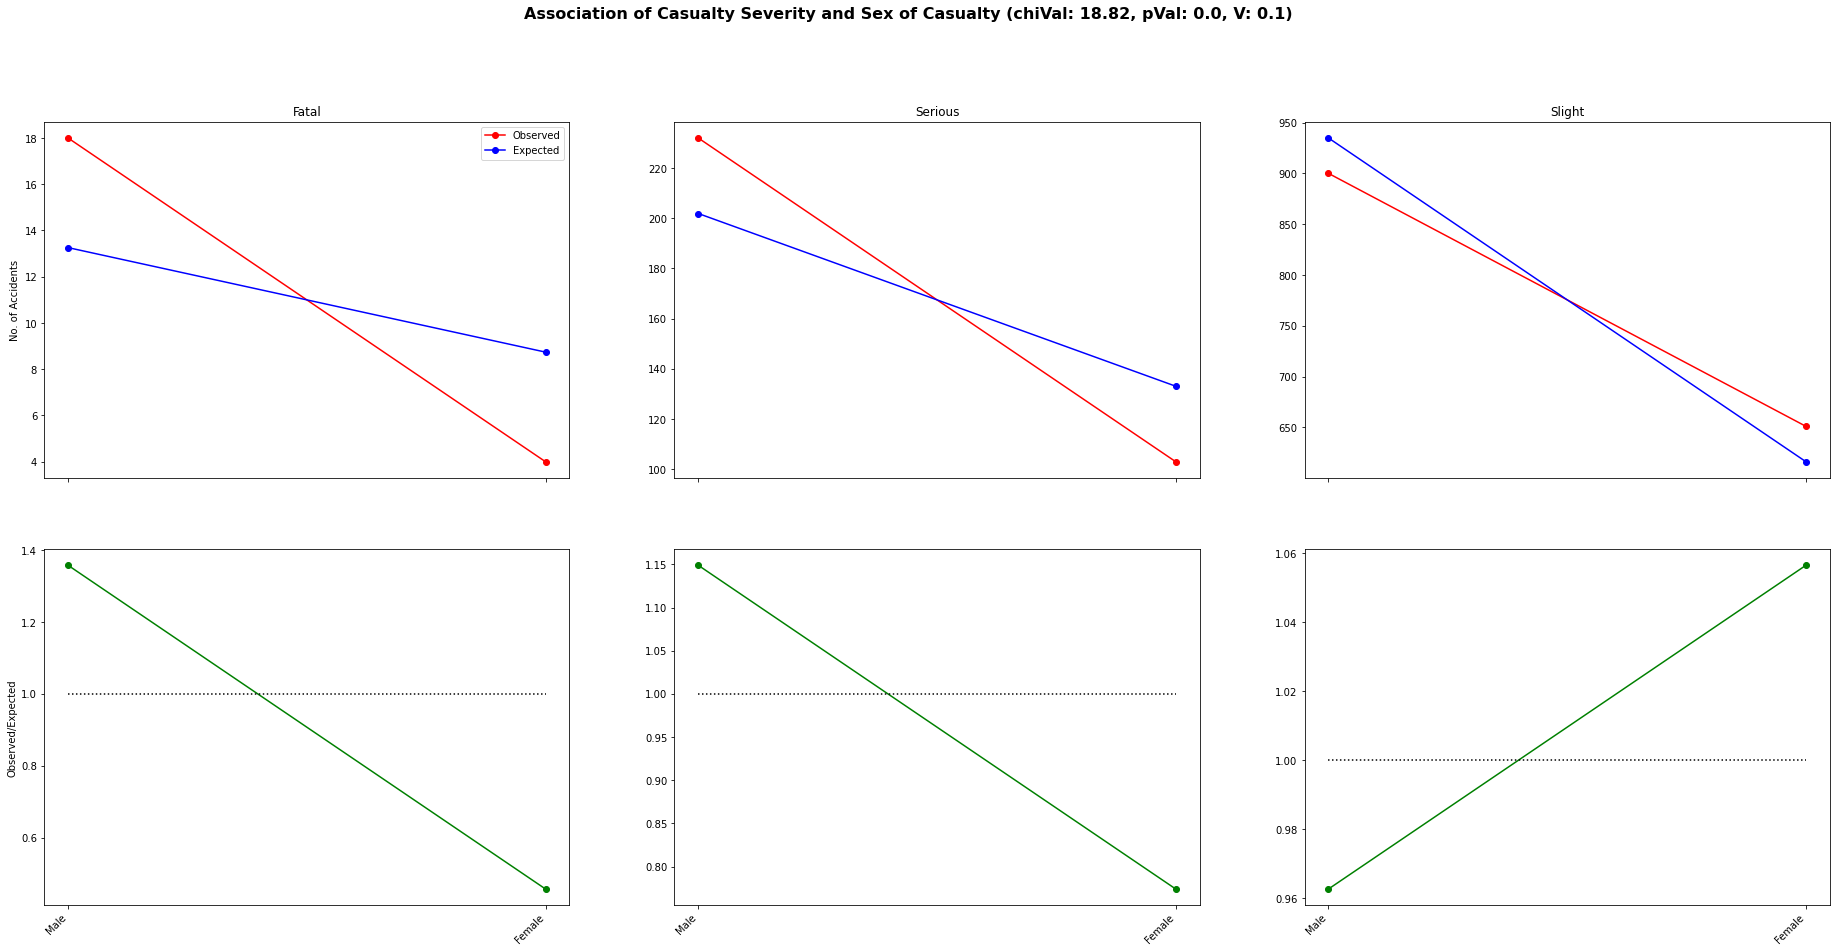

In [120]:
categorical_association_test(DATA_LEEDS['casualties'], SUMMARY['casualties'][7], SUMMARY['casualties'][4])

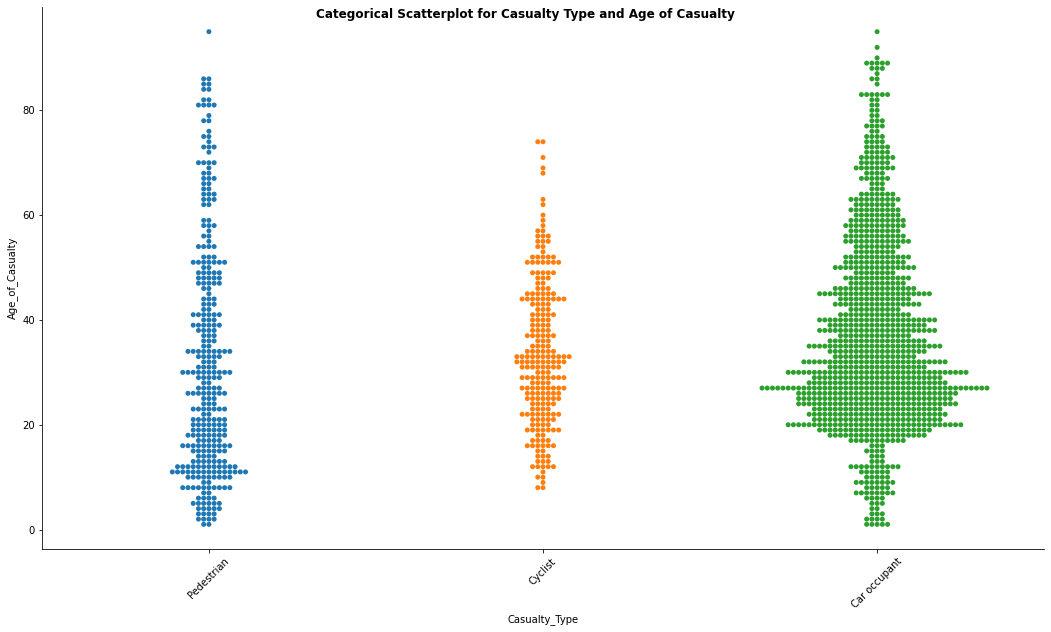

In [26]:
categorical_scatterplot(DATA_LEEDS['casualties'], SUMMARY['casualties'][13], SUMMARY['casualties'][5], _kind='svarm', _exclude=100)

In [ ]:
?save_figure

Saved: '0.14_6_11_Accident_Severity_Time.pdf' to ../reports/accidents/associations/chi_squared/Accident_Severity


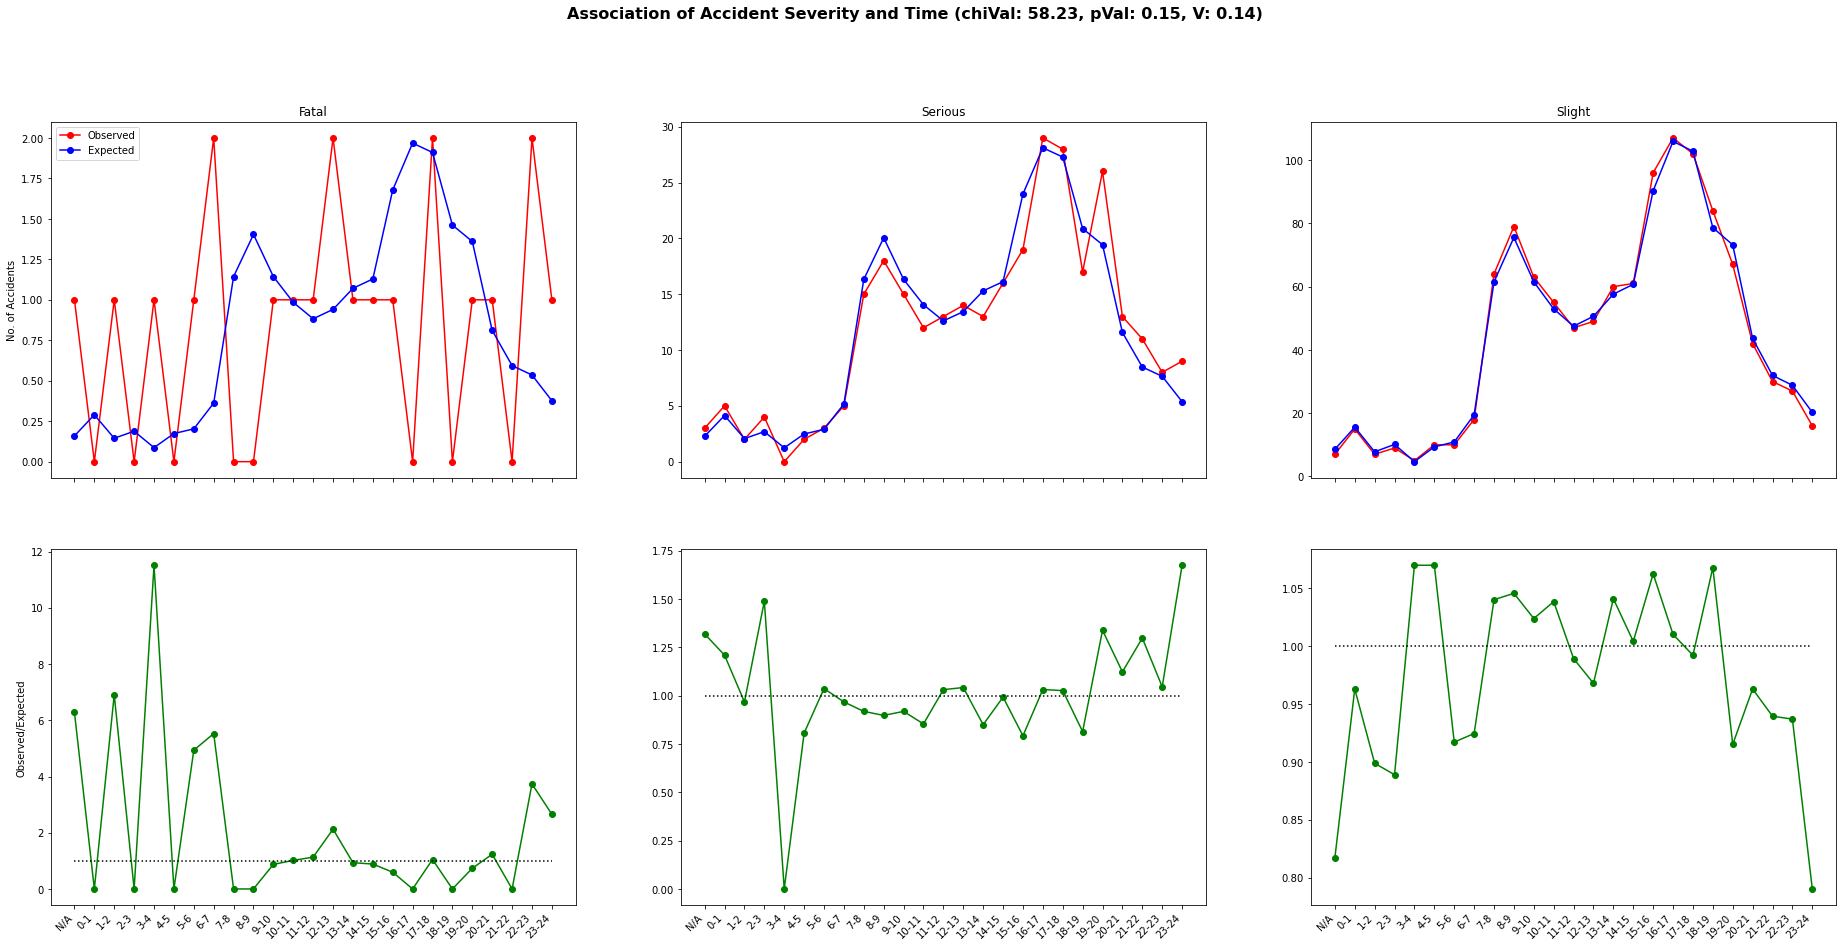

In [38]:
fig, V = categorical_association_test(DATA_LEEDS['accidents'], SUMMARY['accidents'][6], SUMMARY['accidents'][11])
path = PATH['reports']['accidents'] + 'associations/' + 'chi_squared/' + SUMMARY['accidents'][6]['Name']
save_figure(fig, path, column_index=f"{V}_{6}_{11}", column_name=f"{SUMMARY['accidents'][6]['Name']}_{SUMMARY['accidents'][11]['Name']}", dataset_name='accidents', save_to='pdf')

In [43]:
def save_all_categorical_scatters(data, summary, dataset_name):
    for i in range(len(summary)):
        if summary[i]['Plot'] == 'hist':
            for j in range(len(summary)):
                if summary[j]['Plot'] == 'bar':
                    fig = categorical_scatterplot(data, summary[j], summary[i], _kind='svarm')

                    path = PATH['reports'][dataset_name] + 'associations/' + 'categorical_scatters'

                    save_figure(fig, path, column_index=f"{i}_{j}", column_name=f"{summary[i]['Name']}_{summary[j]['Name']}", dataset_name=dataset_name, save_to='pdf')

In [44]:
MARKERS = {}
MARKERS['accidents'] = [6, 7, 8] # severity, #vehicles, #casualties
MARKERS['vehicles'] = []
MARKERS['casualties'] = [7] # severity

In [45]:
def save_all_categorical_associations(data, summary, dataset_name):
    for i in MARKERS[dataset_name]:
        for j in range(len(summary)):
            try: 
                if summary[j]['Map'] and j not in MARKERS[dataset_name] + [5, 12, 13]: # local authority highway and local authority district 
                    fig, V = categorical_association_test(data, summary[i], summary[j])

                    path = PATH['reports'][dataset_name] + 'associations/' + 'chi_squared/' + summary[i]['Name']
                    save_figure(fig, path, column_index=f"{V}_{i}{j}", column_name=f"{summary[i]['Name']}_{summary[j]['Name']}", dataset_name=dataset_name)
            except: None

In [47]:
%%capture 
for dataset in TABLENAMES:
    save_all_categorical_scatters(DATA_LEEDS[dataset], SUMMARY[dataset], dataset)
    save_all_categorical_associations(DATA_LEEDS[dataset], SUMMARY[dataset], dataset)

# Spatial Visualisation (TASK 3)
---

## Create Map of Leeds
---

In [ ]:
leeds_map = folium.Map(location=[53.8008, -1.5491], tiles="Stamen Terrain", initial_zoom = 5)
leeds_map

## Plot all Accidents in Leeds onto Map
--- 

In [ ]:
def plot_point(map, location, color, fill):
    folium.Circle(
            radius=30,
            location=[location[0], location[1]],
            color=color,
            fill=True).add_to(map)

In [ ]:
np.unique(DATA_LEEDS['accidents']['Accident_Severity'], return_counts=True)

In [ ]:
def map_accidents(data, focus='Accident_Severity'):
    uniques = np.unique(data[focus])
    no_uniques = len(uniques)
    # colors = [list(np.random.choice(range(256), size=3)) for _ in range(no_uniques)]
    colors = ['black', 'red', 'green']
    
    for i in range(data.shape[0]):
        for j in range(no_uniques):
            if data[focus].iloc[i] == uniques[j]:
                plot_point(leeds_map, (data['Latitude'].iloc[i], data['Longitude'].iloc[i]), color=colors[j], fill=False)

In [ ]:
map_accidents(DATA_LEEDS['accidents'], focus='Accident_Severity')

In [ ]:
leeds_map

## Save Map Visualisation
---

In [ ]:
def save_map(map_, index, name):
    try:
        os.makedirs(f'../reports/maps')
    except: None

    map_.save(f'../reports/maps/{index}_{name}_map.html')

# Bike Safety in Leeds (TASK 4)
---

## Filtering for Bike Accidents
---

In [ ]:
DATA_LEEDS_BIKES['vehicles'] = DATA_LEEDS['vehicles'][DATA_LEEDS['vehicles']['Vehicle_Type'] == 1]

In [ ]:
bike_accidents_indexes = set(DATA_LEEDS_BIKES['vehicles']['Accident_Index'])
len(bike_accidents_indexes)

In [ ]:
for dataset in TABLENAMES:
    if dataset != 'vehicles':
        DATA_LEEDS_BIKES[dataset] = DATA_LEEDS[dataset][DATA_LEEDS[dataset]['Accident_Index'].isin(bike_accidents_indexes)]